In [1]:
!pip install -q ../input/nfl-lib/timm-0.1.26-py3-none-any.whl
!tar xfz ../input/nfl-lib/pkgs.tgz
cmd = "sed -i -e 's/ \/ / \/\/ /' timm-efficientdet-pytorch/effdet/bench.py"
!$cmd

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import sys
sys.path.insert(0, "timm-efficientdet-pytorch")
sys.path.insert(0, "omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
import pandas as pd
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchEval
from effdet.efficientdet import HeadNet
from tqdm import tqdm
import pydicom
import warnings
import imagesize
from ensemble_boxes import *
warnings.filterwarnings("ignore")

In [3]:
SEED = 1312

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [4]:
iou_thr = 0.4
N_CLASSES = 14
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
df = pd.read_csv(r'../input/vinbigdata-chest-xray-abnormalities-detection/train.csv')
df = pd.DataFrame(df)
df = df[df['class_name'] != 'No finding']
image_ids = df['image_id'].unique()
train_ids = image_ids[:4000]
valid_ids = image_ids[4000:]
valid_df = df[df['image_id'].isin(valid_ids)]
train_df = df[df['image_id'].isin(train_ids)]

In [5]:
def get_train_transforms():
    return A.Compose(
        [
            A.ToGray(p=0.1),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.8),
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.8),
            ], p=0.5),
            A.OneOf([
                A.Blur(blur_limit=3, p=0.8),
                A.MedianBlur(blur_limit=3, p=0.8)
            ],p=0.2),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.2),
            A.RandomRotate90(p=0.1),
            A.Transpose(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=1, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            A.Cutout(num_holes=1, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            A.Cutout(num_holes=1, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            A.Cutout(num_holes=1, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            A.Cutout(num_holes=4, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            A.Cutout(num_holes=2, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [6]:
def run_wbf(boxes, labels, w, h, iou_thr):
    scores = [np.array([0.9]*len(boxes))]
    
    boxes[:, 0] = (boxes[:, 0] / w)
    boxes[:, 1] = (boxes[:, 1] / h)
    boxes[:, 2] = (boxes[:, 2] / w)
    boxes[:, 3] = (boxes[:, 3] / h)
    boxes = [boxes]
    
    labels = [labels]
    
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr,
                                                  skip_box_thr=0.001)
    boxes[:, 0] = (boxes[:, 0] * w)
    boxes[:, 1] = (boxes[:, 1] * h)
    boxes[:, 2] = (boxes[:, 2] * w)
    boxes[:, 3] = (boxes[:, 3] * h)
    return boxes, labels

In [7]:
class DatasetRetriever(Dataset):

    def __init__(self, marking, image_dir, transforms=None, test=False):
        super().__init__()

        self.image_ids = marking["image_id"].unique()
        self.image_dir = image_dir
        self.image_original_dir = '../input/vinbigdata-original-image-dataset/vinbigdata/train'
        self.marking = marking
        self.transforms = transforms
        self.test = test
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        image, boxes, labels = self.load_image_and_boxes(index)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels)
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break
        return image, target, image_id
    
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        w,h = imagesize.get(f'{self.image_original_dir}/{image_id}.jpg')
        dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")
        image = dicom.pixel_array
        if "PhotometricInterpretation" in dicom:
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                image = np.amax(image) - image
        
        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image/4095
        image = image.transpose(1, 2, 0)
        
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        labels = records['class_id'].values
        boxes, labels = run_wbf(boxes, labels, w, h, iou_thr)
        return image, boxes, labels

In [8]:
image_paths = '../input/vinbigdata-chest-xray-abnormalities-detection/train'
train_dataset = DatasetRetriever(
    marking=train_df,
    image_dir=image_paths,
    transforms=get_train_transforms(),
    test = False
)

validation_dataset = DatasetRetriever(
    marking=valid_df,
    image_dir=image_paths,
    transforms=get_valid_transforms(),
    test = True
)

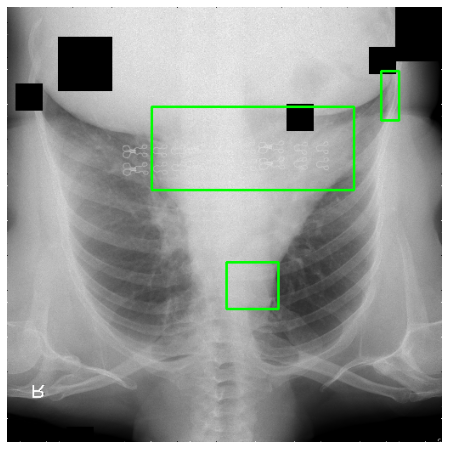

In [9]:
image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int64)

numpy_image = image.permute(1, 2, 0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3], box[2]), (0, 1, 0), 2)

ax.set_axis_off()
ax.imshow(numpy_image)
plt.show()

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [12]:
class TrainGlobalConfig:
    num_workers = 4
    batch_size = 4
    n_epochs = 6
    lr = 0.0001
    folder = 'models'
    verbose = True
    verbose_step = 1
    step_scheduler = False
    validation_scheduler = True
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [14]:
def get_net():
    config = get_efficientdet_config('tf_efficientdet_d7')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('../input/efficientdet/efficientdet_d7-f05bf714.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 14
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()

In [15]:
run_training()

Fitter prepared. Device is cuda

2021-01-25T06:08:25.250824
LR: 0.0001
[RESULT]: Train. Epoch: 0, summary_loss: 137.02794, time: 4365.10285
[RESULT]: Val. Epoch: 0, summary_loss: 7.61720, time: 338.67036

2021-01-25T07:26:51.774400
LR: 0.0001
[RESULT]: Train. Epoch: 1, summary_loss: 2.70391, time: 4180.43256
[RESULT]: Val. Epoch: 1, summary_loss: 2.08454, time: 338.95330

2021-01-25T08:42:14.344570
LR: 0.0001
[RESULT]: Train. Epoch: 2, summary_loss: 1.37668, time: 4185.80503
[RESULT]: Val. Epoch: 2, summary_loss: 1.09339, time: 338.36662

2021-01-25T09:57:42.276906
LR: 0.0001
[RESULT]: Train. Epoch: 3, summary_loss: 1.06333, time: 4334.75011
[RESULT]: Val. Epoch: 3, summary_loss: 0.87886, time: 373.11835

2021-01-25T11:16:13.461030
LR: 0.0001
[RESULT]: Train. Epoch: 4, summary_loss: 0.94400, time: 4459.21597
[RESULT]: Val. Epoch: 4, summary_loss: 0.74975, time: 333.40237

2021-01-25T12:36:09.253004
LR: 0.0001
[RESULT]: Train. Epoch: 5, summary_loss: 0.87710, time: 4100.93892
[RESULT]: 

In [16]:
!rm -rf omegaconf
!rm -rf timm-efficientdet-pytorch